# MNIST WAE-MMD

9 January 2019

In [1]:
## Add the master directory to the path
import sys
sys.path.append('../')

In [2]:
## Load the relevant modules
import functools
import os

from tqdm import tqdm as tqdm
import torch
from torch.nn import functional as F
from torch import optim
from torch.utils import data
from torchvision import datasets
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

import autoencoders as ae

In [3]:
## Set up the parameters 
params = ae.examples.MnistWaeParams()

params.batch_size = 100
params.lambda_ = 10
params.test_batch_size = 500
params.num_epochs = 100
params.device = torch.device('cuda:0')  # change to GPU if you want to train there
params.learning_rate = 1e-3
params.adam_beta_1 = 0.5
params.adam_beta_2 = 0.999
params.learning_rate_epoch_to_decay_factor_map = {30:2., 50:5.}

# We are not doing:
# * the two heuristics suggested on p.17


In [4]:
# Create the datasets
trsfms = transforms.Compose([transforms.ToTensor(), lambda x: x.view(1,28,28)])

dataset = datasets.MNIST('mnist', train=True, download=True,
                                transform=trsfms)
test_dataset = datasets.MNIST('mnist', train=False, download=True,
                         transform=trsfms)

# Create the data loaders.
train_dataloader = data.DataLoader(dataset, batch_size=params.batch_size, shuffle=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=params.test_batch_size, shuffle=False)



In [5]:
## Set up the training function

def train(data_loader, optimizer, batch_size, device, wae):
    wae.train() # put in train mode
    with tqdm(data_loader, total=len(data_loader.dataset) / batch_size) as t:
        for data_batch in t:
            data_batch_x = data_batch[0].to(device)
            optimizer.zero_grad()
            obj = wae.objective_to_maximise(data_batch_x, params.lambda_).mean()
            loss = -obj
            loss.backward()
            optimizer.step()
            t.set_postfix(wae_obj=obj.item())  # update the progress bar




In [6]:
## Set up the validation function
def test(data_loader, batch_size, device, wae, epoch_num, plot_reconstructions=True):
    wae.eval()

    obj_batch_size = []
    start = True
    with tqdm(data_loader, total=len(data_loader.dataset) / batch_size) as t:
        for data_batch in t:
            data_batch_x = data_batch[0].to(device)
            with torch.no_grad():
                obj = wae.objective_to_maximise(data_batch_x, params.lambda_).mean()
            obj_batch_size.append((obj.item(), data_batch_x.shape[0]))

            if plot_reconstructions and start:
                reconstruction_ = wae.reconstruct_no_grad(data_batch_x).cpu()
                reconstruction_ = reconstruction_[:100]
                img_grid = make_grid(reconstruction_.view(-1,1, 28,28).cpu(), nrow=10).numpy()
                f, ax = plt.subplots(figsize=(8, 8))
                ax.imshow(np.transpose(img_grid, (1,2,0)), vmin=0, vmax=1.)
                plt.title(f"Reconstruction on epoch {epoch_num}.")
                plt.show()
                start = False

    avg_obj = functools.reduce(lambda x, y: ((x[0]*x[1] + y[0]*y[1]) / (x[1] + y[1])  # avg
                                                , x[1] + y[1]),  # total points
                               obj_batch_size)
    print(f"Run through the test dataset ({avg_obj[1]} num of points). Average (per image) WAE objective was {avg_obj[0]:.4f}\n")


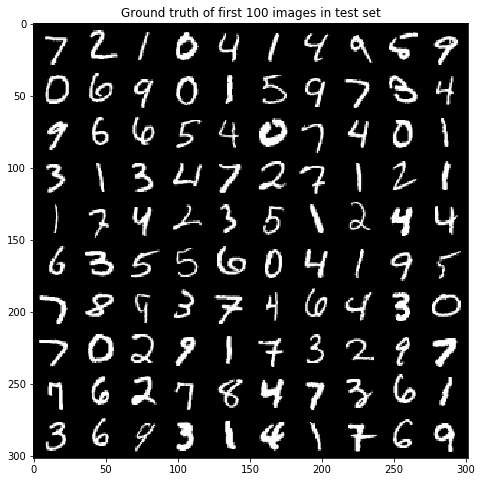

In [7]:
# We shall plot the first 100 of the test set as this is what we shall be trying to reconstruct
# So tells us what we are aiming for.

first_batch = next(iter(test_dataloader))[0][:100]
# ^ 0 for the x data.

img_grid = make_grid(first_batch.view(-1,1, 28,28).cpu(), nrow=10).numpy()
f, ax = plt.subplots(figsize=(8, 8))
ax.imshow(np.transpose(img_grid, (1,2,0)), vmin=0, vmax=1.)
plt.title('Ground truth of first 100 images in test set')
plt.show()

  0%|          | 0/20.0 [00:00<?, ?it/s]

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


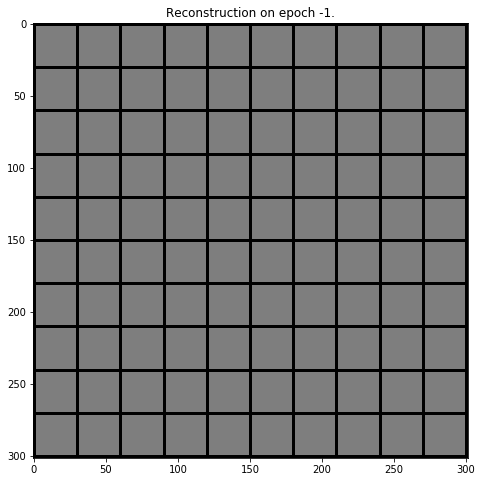

100%|██████████| 20/20.0 [00:05<00:00,  3.79it/s]
  0%|          | 1/600.0 [00:00<01:24,  7.11it/s, wae_obj=-177]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -180.7338



Starting epoch 0


100%|██████████| 600/600.0 [01:22<00:00,  7.28it/s, wae_obj=-16.3]
  0%|          | 0/20.0 [00:00<?, ?it/s]

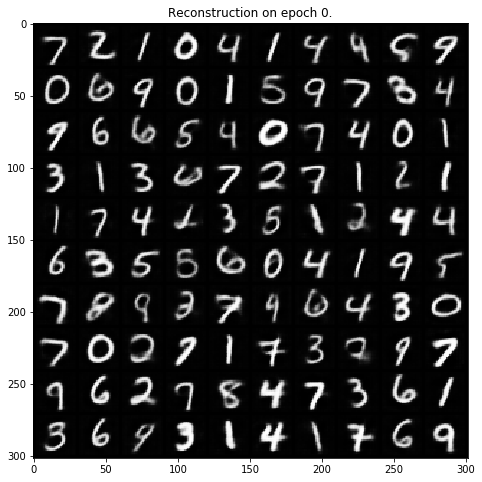

100%|██████████| 20/20.0 [00:05<00:00,  3.89it/s]
  0%|          | 1/600.0 [00:00<01:23,  7.18it/s, wae_obj=-15.8]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -14.5892



Starting epoch 1


100%|██████████| 600/600.0 [01:22<00:00,  7.17it/s, wae_obj=-13.3]
  0%|          | 0/20.0 [00:00<?, ?it/s]

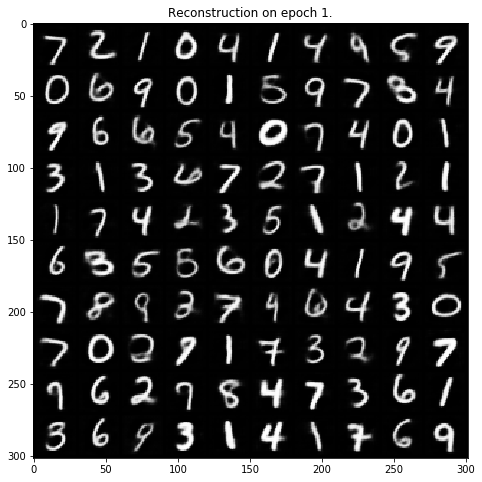

100%|██████████| 20/20.0 [00:05<00:00,  4.03it/s]
  0%|          | 1/600.0 [00:00<01:22,  7.29it/s, wae_obj=-12.2]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -12.4323



Starting epoch 2


100%|██████████| 600/600.0 [01:22<00:00,  7.22it/s, wae_obj=-13.3]
  0%|          | 0/20.0 [00:00<?, ?it/s]

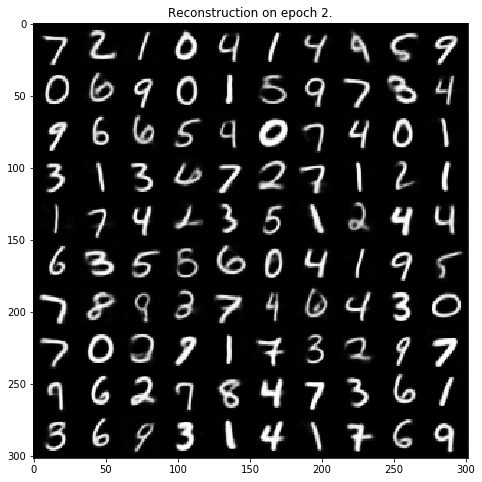

100%|██████████| 20/20.0 [00:05<00:00,  3.93it/s]
  0%|          | 1/600.0 [00:00<01:23,  7.19it/s, wae_obj=-12.6]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -11.5214



Starting epoch 3


100%|██████████| 600/600.0 [01:22<00:00,  7.24it/s, wae_obj=-11.6]
  0%|          | 0/20.0 [00:00<?, ?it/s]

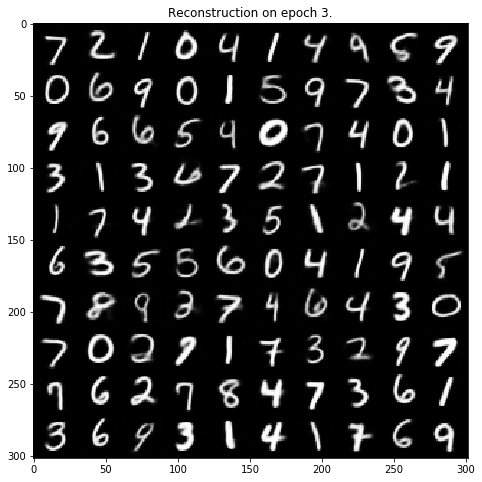

100%|██████████| 20/20.0 [00:05<00:00,  3.97it/s]
  0%|          | 1/600.0 [00:00<01:27,  6.83it/s, wae_obj=-13]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -11.3861



Starting epoch 4


100%|██████████| 600/600.0 [01:23<00:00,  7.14it/s, wae_obj=-11.7]
  0%|          | 0/20.0 [00:00<?, ?it/s]

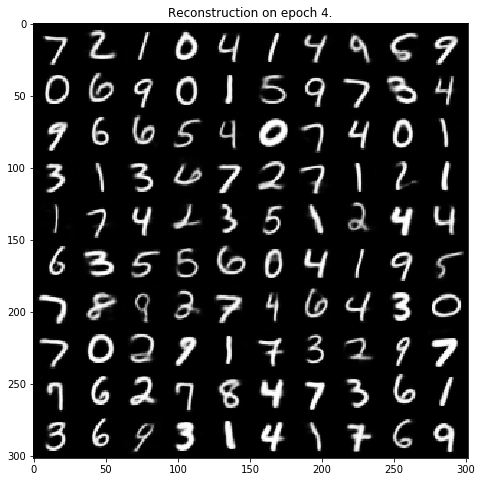

100%|██████████| 20/20.0 [00:05<00:00,  3.99it/s]
  0%|          | 1/600.0 [00:00<01:24,  7.11it/s, wae_obj=-11]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -10.7227



Starting epoch 5


100%|██████████| 600/600.0 [01:23<00:00,  7.26it/s, wae_obj=-9.62]
100%|██████████| 20/20.0 [00:05<00:00,  3.98it/s]
  0%|          | 1/600.0 [00:00<01:22,  7.23it/s, wae_obj=-9.84]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -10.2972



Starting epoch 6


100%|██████████| 600/600.0 [01:23<00:00,  7.24it/s, wae_obj=-11.3]
100%|██████████| 20/20.0 [00:05<00:00,  3.99it/s]
  0%|          | 1/600.0 [00:00<01:26,  6.95it/s, wae_obj=-10]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -10.6534



Starting epoch 7


100%|██████████| 600/600.0 [01:22<00:00,  7.29it/s, wae_obj=-8.74]
100%|██████████| 20/20.0 [00:05<00:00,  3.81it/s]
  0%|          | 1/600.0 [00:00<01:23,  7.20it/s, wae_obj=-9.85]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -10.1180



Starting epoch 8


100%|██████████| 600/600.0 [01:23<00:00,  7.28it/s, wae_obj=-9.7] 
100%|██████████| 20/20.0 [00:05<00:00,  3.89it/s]
  0%|          | 1/600.0 [00:00<01:27,  6.83it/s, wae_obj=-8.74]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.6844



Starting epoch 9


100%|██████████| 600/600.0 [01:22<00:00,  7.31it/s, wae_obj=-8.06]
100%|██████████| 20/20.0 [00:05<00:00,  3.98it/s]
  0%|          | 1/600.0 [00:00<01:25,  7.00it/s, wae_obj=-8.51]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.5843



Starting epoch 10


100%|██████████| 600/600.0 [01:22<00:00,  7.16it/s, wae_obj=-9.92]
  0%|          | 0/20.0 [00:00<?, ?it/s]

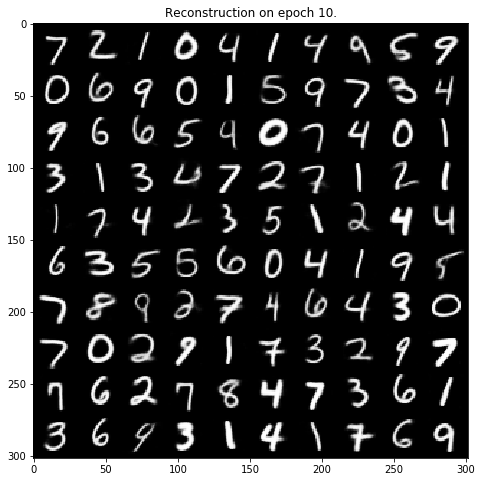

100%|██████████| 20/20.0 [00:05<00:00,  4.01it/s]
  0%|          | 1/600.0 [00:00<01:30,  6.63it/s, wae_obj=-8.9]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.5239



Starting epoch 11


100%|██████████| 600/600.0 [01:23<00:00,  6.98it/s, wae_obj=-8.76]
100%|██████████| 20/20.0 [00:05<00:00,  4.05it/s]
  0%|          | 1/600.0 [00:00<01:21,  7.38it/s, wae_obj=-8.54]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.4260



Starting epoch 12


100%|██████████| 600/600.0 [01:23<00:00,  7.27it/s, wae_obj=-8.25]
100%|██████████| 20/20.0 [00:05<00:00,  3.91it/s]
  0%|          | 1/600.0 [00:00<01:24,  7.06it/s, wae_obj=-9.12]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.6004



Starting epoch 13


100%|██████████| 600/600.0 [01:22<00:00,  7.35it/s, wae_obj=-10]  
100%|██████████| 20/20.0 [00:05<00:00,  3.92it/s]
  0%|          | 1/600.0 [00:00<01:22,  7.27it/s, wae_obj=-9.73]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.5587



Starting epoch 14


100%|██████████| 600/600.0 [01:22<00:00,  7.32it/s, wae_obj=-8.58]
100%|██████████| 20/20.0 [00:05<00:00,  3.99it/s]
  0%|          | 1/600.0 [00:00<01:25,  6.98it/s, wae_obj=-8.7]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.2783



Starting epoch 15


100%|██████████| 600/600.0 [01:22<00:00,  7.27it/s, wae_obj=-8.16]
100%|██████████| 20/20.0 [00:05<00:00,  4.02it/s]
  0%|          | 1/600.0 [00:00<01:24,  7.06it/s, wae_obj=-8.3]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.8139



Starting epoch 16


100%|██████████| 600/600.0 [01:22<00:00,  7.18it/s, wae_obj=-7.96]
100%|██████████| 20/20.0 [00:05<00:00,  3.99it/s]
  0%|          | 1/600.0 [00:00<01:25,  6.99it/s, wae_obj=-8.27]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.1647



Starting epoch 17


100%|██████████| 600/600.0 [01:22<00:00,  7.21it/s, wae_obj=-9.16]
100%|██████████| 20/20.0 [00:05<00:00,  4.02it/s]
  0%|          | 1/600.0 [00:00<01:22,  7.25it/s, wae_obj=-8.12]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.1872



Starting epoch 18


100%|██████████| 600/600.0 [01:22<00:00,  7.24it/s, wae_obj=-8.4] 
100%|██████████| 20/20.0 [00:05<00:00,  3.95it/s]
  0%|          | 1/600.0 [00:00<01:25,  7.02it/s, wae_obj=-8.94]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.3576



Starting epoch 19


100%|██████████| 600/600.0 [01:22<00:00,  7.25it/s, wae_obj=-8.14]
100%|██████████| 20/20.0 [00:05<00:00,  3.98it/s]
  0%|          | 1/600.0 [00:00<01:24,  7.12it/s, wae_obj=-8.09]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.0947



Starting epoch 20


100%|██████████| 600/600.0 [01:22<00:00,  7.21it/s, wae_obj=-9.57]
  0%|          | 0/20.0 [00:00<?, ?it/s]

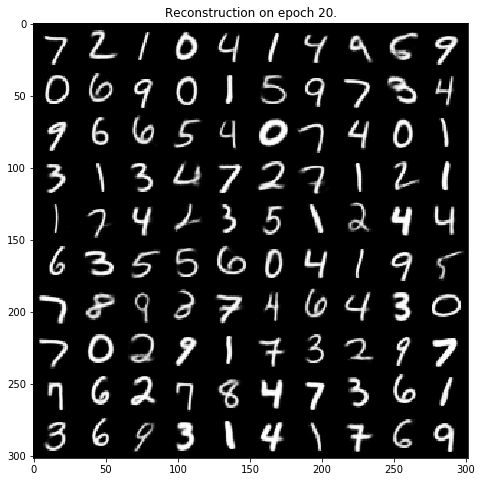

100%|██████████| 20/20.0 [00:05<00:00,  3.93it/s]
  0%|          | 1/600.0 [00:00<01:22,  7.26it/s, wae_obj=-8.19]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.3303



Starting epoch 21


100%|██████████| 600/600.0 [01:23<00:00,  7.21it/s, wae_obj=-9]   
100%|██████████| 20/20.0 [00:05<00:00,  3.99it/s]
  0%|          | 1/600.0 [00:00<01:22,  7.28it/s, wae_obj=-7.82]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.2223



Starting epoch 22


100%|██████████| 600/600.0 [01:22<00:00,  7.18it/s, wae_obj=-7.49]
100%|██████████| 20/20.0 [00:05<00:00,  3.96it/s]
  0%|          | 1/600.0 [00:00<01:24,  7.06it/s, wae_obj=-8.38]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.2205



Starting epoch 23


100%|██████████| 600/600.0 [01:22<00:00,  7.22it/s, wae_obj=-7.58]
100%|██████████| 20/20.0 [00:05<00:00,  3.88it/s]
  0%|          | 1/600.0 [00:00<01:23,  7.16it/s, wae_obj=-8.34]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.1323



Starting epoch 24


100%|██████████| 600/600.0 [01:23<00:00,  7.30it/s, wae_obj=-7.04]
100%|██████████| 20/20.0 [00:05<00:00,  3.87it/s]
  0%|          | 1/600.0 [00:00<01:23,  7.17it/s, wae_obj=-7.3]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.0835



Starting epoch 25


100%|██████████| 600/600.0 [01:22<00:00,  7.12it/s, wae_obj=-8]   
100%|██████████| 20/20.0 [00:05<00:00,  3.92it/s]
  0%|          | 1/600.0 [00:00<01:23,  7.16it/s, wae_obj=-7.51]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.0710



Starting epoch 26


100%|██████████| 600/600.0 [01:22<00:00,  7.26it/s, wae_obj=-7.7] 
100%|██████████| 20/20.0 [00:05<00:00,  3.96it/s]
  0%|          | 1/600.0 [00:00<01:25,  7.03it/s, wae_obj=-7.23]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.0656



Starting epoch 27


100%|██████████| 600/600.0 [01:22<00:00,  7.29it/s, wae_obj=-7.16]
100%|██████████| 20/20.0 [00:05<00:00,  3.83it/s]
  0%|          | 1/600.0 [00:00<01:23,  7.18it/s, wae_obj=-7.47]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.1231



Starting epoch 28


100%|██████████| 600/600.0 [01:23<00:00,  7.31it/s, wae_obj=-7.07]
100%|██████████| 20/20.0 [00:05<00:00,  3.96it/s]
  0%|          | 1/600.0 [00:00<01:26,  6.92it/s, wae_obj=-7.25]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.0750



Starting epoch 29


100%|██████████| 600/600.0 [01:22<00:00,  7.14it/s, wae_obj=-7.36]
100%|██████████| 20/20.0 [00:05<00:00,  3.98it/s]
  0%|          | 1/600.0 [00:00<01:24,  7.08it/s, wae_obj=-7.44]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.2723



Starting epoch 30
Reached epoch 30 so decaying learning rates by 2.0, optimizer is now:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)


100%|██████████| 600/600.0 [01:23<00:00,  7.19it/s, wae_obj=-6.7] 
  0%|          | 0/20.0 [00:00<?, ?it/s]

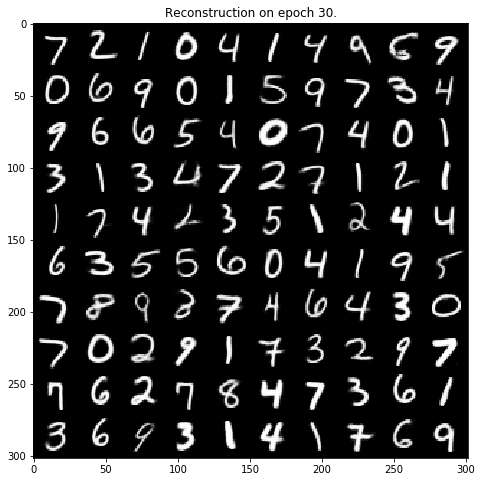

100%|██████████| 20/20.0 [00:05<00:00,  3.97it/s]
  0%|          | 1/600.0 [00:00<01:25,  7.04it/s, wae_obj=-6.46]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -8.8349



Starting epoch 31


100%|██████████| 600/600.0 [01:38<00:00,  6.05it/s, wae_obj=-6.68]
100%|██████████| 20/20.0 [00:07<00:00,  2.68it/s]
  0%|          | 1/600.0 [00:00<01:44,  5.72it/s, wae_obj=-7.19]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.1981



Starting epoch 32


100%|██████████| 600/600.0 [01:39<00:00,  6.16it/s, wae_obj=-6.92]
100%|██████████| 20/20.0 [00:06<00:00,  2.93it/s]
  0%|          | 1/600.0 [00:00<01:41,  5.89it/s, wae_obj=-6.34]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -8.9713



Starting epoch 33


100%|██████████| 600/600.0 [01:39<00:00,  5.95it/s, wae_obj=-7.09]
100%|██████████| 20/20.0 [00:06<00:00,  2.95it/s]
  0%|          | 1/600.0 [00:00<01:43,  5.79it/s, wae_obj=-6.59]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -8.9995



Starting epoch 34


100%|██████████| 600/600.0 [01:38<00:00,  6.33it/s, wae_obj=-7.21]
100%|██████████| 20/20.0 [00:06<00:00,  2.96it/s]
  0%|          | 1/600.0 [00:00<01:35,  6.26it/s, wae_obj=-6.37]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.0718



Starting epoch 35


100%|██████████| 600/600.0 [01:39<00:00,  5.86it/s, wae_obj=-6.12]
100%|██████████| 20/20.0 [00:06<00:00,  2.96it/s]
  0%|          | 1/600.0 [00:00<01:34,  6.31it/s, wae_obj=-6.44]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.0479



Starting epoch 36


100%|██████████| 600/600.0 [01:39<00:00,  6.05it/s, wae_obj=-5.68]
100%|██████████| 20/20.0 [00:06<00:00,  2.92it/s]
  0%|          | 1/600.0 [00:00<01:46,  5.63it/s, wae_obj=-5.73]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.2436



Starting epoch 37


100%|██████████| 600/600.0 [01:39<00:00,  5.88it/s, wae_obj=-6.45]
100%|██████████| 20/20.0 [00:06<00:00,  2.86it/s]
  0%|          | 1/600.0 [00:00<01:35,  6.28it/s, wae_obj=-5.39]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.1293



Starting epoch 38


100%|██████████| 600/600.0 [01:39<00:00,  6.03it/s, wae_obj=-6.57]
100%|██████████| 20/20.0 [00:06<00:00,  3.05it/s]
  0%|          | 1/600.0 [00:00<01:39,  6.04it/s, wae_obj=-5.74]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.1252



Starting epoch 39


100%|██████████| 600/600.0 [01:39<00:00,  6.13it/s, wae_obj=-6.65]
100%|██████████| 20/20.0 [00:06<00:00,  2.99it/s]
  0%|          | 1/600.0 [00:00<01:54,  5.23it/s, wae_obj=-5.89]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.0807



Starting epoch 40


100%|██████████| 600/600.0 [01:39<00:00,  5.93it/s, wae_obj=-5.78]
  0%|          | 0/20.0 [00:00<?, ?it/s]

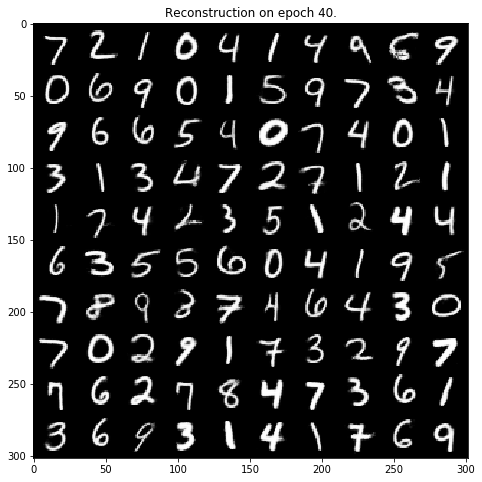

100%|██████████| 20/20.0 [00:07<00:00,  3.01it/s]
  0%|          | 1/600.0 [00:00<01:37,  6.16it/s, wae_obj=-6.03]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.1233



Starting epoch 41


100%|██████████| 600/600.0 [01:38<00:00,  6.10it/s, wae_obj=-5.94]
100%|██████████| 20/20.0 [00:06<00:00,  2.95it/s]
  0%|          | 1/600.0 [00:00<01:36,  6.21it/s, wae_obj=-5.59]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.2655



Starting epoch 42


100%|██████████| 600/600.0 [01:39<00:00,  6.07it/s, wae_obj=-5.73]
100%|██████████| 20/20.0 [00:06<00:00,  2.96it/s]
  0%|          | 1/600.0 [00:00<01:43,  5.80it/s, wae_obj=-5.42]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.2689



Starting epoch 43


100%|██████████| 600/600.0 [01:40<00:00,  6.01it/s, wae_obj=-5.84]
100%|██████████| 20/20.0 [00:06<00:00,  3.01it/s]
  0%|          | 1/600.0 [00:00<01:35,  6.27it/s, wae_obj=-6.22]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.2285



Starting epoch 44


100%|██████████| 600/600.0 [01:39<00:00,  6.12it/s, wae_obj=-5.45]
100%|██████████| 20/20.0 [00:06<00:00,  2.94it/s]
  0%|          | 1/600.0 [00:00<01:42,  5.84it/s, wae_obj=-5.61]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.2390



Starting epoch 45


100%|██████████| 600/600.0 [01:38<00:00,  6.17it/s, wae_obj=-5.21]
100%|██████████| 20/20.0 [00:06<00:00,  2.90it/s]
  0%|          | 1/600.0 [00:00<01:37,  6.12it/s, wae_obj=-5.68]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.2669



Starting epoch 46


100%|██████████| 600/600.0 [01:39<00:00,  6.06it/s, wae_obj=-5.96]
100%|██████████| 20/20.0 [00:06<00:00,  2.94it/s]
  0%|          | 1/600.0 [00:00<01:39,  6.03it/s, wae_obj=-5.12]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.2453



Starting epoch 47


100%|██████████| 600/600.0 [01:39<00:00,  6.24it/s, wae_obj=-6.38]
100%|██████████| 20/20.0 [00:06<00:00,  3.14it/s]
  0%|          | 1/600.0 [00:00<01:42,  5.82it/s, wae_obj=-6.23]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.3267



Starting epoch 48


100%|██████████| 600/600.0 [01:39<00:00,  6.00it/s, wae_obj=-5.4] 
100%|██████████| 20/20.0 [00:06<00:00,  2.94it/s]
  0%|          | 1/600.0 [00:00<01:47,  5.59it/s, wae_obj=-5.63]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.2998



Starting epoch 49


100%|██████████| 600/600.0 [01:39<00:00,  5.90it/s, wae_obj=-6.1] 
100%|██████████| 20/20.0 [00:06<00:00,  3.18it/s]
  0%|          | 1/600.0 [00:00<01:42,  5.84it/s, wae_obj=-5.93]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.3828



Starting epoch 50
Reached epoch 50 so decaying learning rates by 5.0, optimizer is now:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)


100%|██████████| 600/600.0 [01:38<00:00,  5.94it/s, wae_obj=-5.3] 
  0%|          | 0/20.0 [00:00<?, ?it/s]

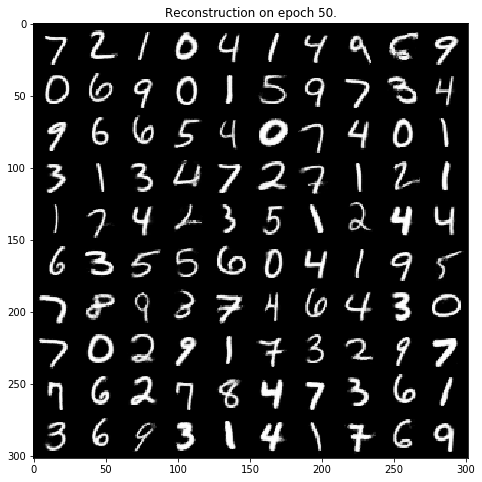

100%|██████████| 20/20.0 [00:07<00:00,  2.94it/s]
  0%|          | 1/600.0 [00:00<01:36,  6.22it/s, wae_obj=-5.35]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.2557



Starting epoch 51


100%|██████████| 600/600.0 [01:39<00:00,  5.85it/s, wae_obj=-5.23]
100%|██████████| 20/20.0 [00:06<00:00,  3.02it/s]
  0%|          | 1/600.0 [00:00<01:35,  6.28it/s, wae_obj=-4.84]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.2757



Starting epoch 52


100%|██████████| 600/600.0 [01:39<00:00,  6.24it/s, wae_obj=-5.45]
100%|██████████| 20/20.0 [00:06<00:00,  2.88it/s]
  0%|          | 1/600.0 [00:00<01:41,  5.88it/s, wae_obj=-4.93]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.3346



Starting epoch 53


100%|██████████| 600/600.0 [01:39<00:00,  6.06it/s, wae_obj=-4.91]
100%|██████████| 20/20.0 [00:07<00:00,  2.85it/s]
  0%|          | 1/600.0 [00:00<01:40,  5.97it/s, wae_obj=-4.36]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.3114



Starting epoch 54


100%|██████████| 600/600.0 [01:39<00:00,  5.45it/s, wae_obj=-5.2] 
100%|██████████| 20/20.0 [00:06<00:00,  2.91it/s]
  0%|          | 1/600.0 [00:00<01:46,  5.62it/s, wae_obj=-4.49]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.3890



Starting epoch 55


100%|██████████| 600/600.0 [01:39<00:00,  5.86it/s, wae_obj=-5.48]
100%|██████████| 20/20.0 [00:06<00:00,  3.04it/s]
  0%|          | 1/600.0 [00:00<01:38,  6.09it/s, wae_obj=-4.87]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.4300



Starting epoch 56


100%|██████████| 600/600.0 [01:38<00:00,  6.08it/s, wae_obj=-5.32]
100%|██████████| 20/20.0 [00:06<00:00,  3.01it/s]
  0%|          | 1/600.0 [00:00<01:38,  6.09it/s, wae_obj=-4.57]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.4017



Starting epoch 57


100%|██████████| 600/600.0 [01:39<00:00,  5.81it/s, wae_obj=-4.25]
100%|██████████| 20/20.0 [00:06<00:00,  2.99it/s]
  0%|          | 1/600.0 [00:00<01:38,  6.06it/s, wae_obj=-4.86]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.4413



Starting epoch 58


100%|██████████| 600/600.0 [01:39<00:00,  6.19it/s, wae_obj=-5.19]
100%|██████████| 20/20.0 [00:06<00:00,  3.03it/s]
  0%|          | 1/600.0 [00:00<01:35,  6.25it/s, wae_obj=-5.2]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.4855



Starting epoch 59


100%|██████████| 600/600.0 [01:39<00:00,  6.09it/s, wae_obj=-4.88]
100%|██████████| 20/20.0 [00:06<00:00,  3.09it/s]
  0%|          | 1/600.0 [00:00<01:36,  6.20it/s, wae_obj=-5.12]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.4811



Starting epoch 60


100%|██████████| 600/600.0 [01:38<00:00,  6.12it/s, wae_obj=-4.93]
  0%|          | 0/20.0 [00:00<?, ?it/s]

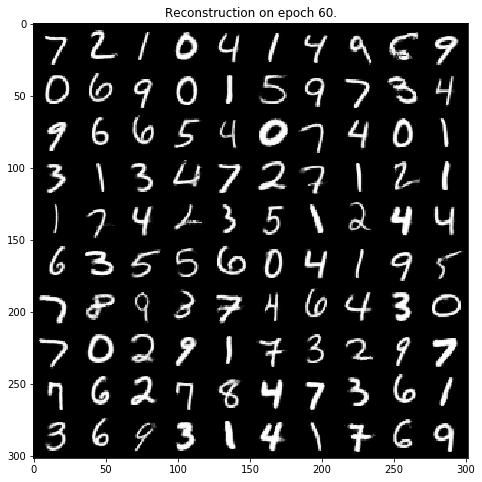

100%|██████████| 20/20.0 [00:07<00:00,  3.23it/s]
  0%|          | 1/600.0 [00:00<01:39,  6.04it/s, wae_obj=-4.93]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.4987



Starting epoch 61


100%|██████████| 600/600.0 [01:38<00:00,  6.10it/s, wae_obj=-4.75]
100%|██████████| 20/20.0 [00:06<00:00,  3.14it/s]
  0%|          | 1/600.0 [00:00<01:34,  6.34it/s, wae_obj=-4.5]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.5048



Starting epoch 62


100%|██████████| 600/600.0 [01:38<00:00,  6.26it/s, wae_obj=-4.62]
100%|██████████| 20/20.0 [00:06<00:00,  3.05it/s]
  0%|          | 1/600.0 [00:00<01:32,  6.49it/s, wae_obj=-4.4]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.5173



Starting epoch 63


100%|██████████| 600/600.0 [01:38<00:00,  6.08it/s, wae_obj=-4.46]
100%|██████████| 20/20.0 [00:06<00:00,  2.93it/s]
  0%|          | 1/600.0 [00:00<01:37,  6.16it/s, wae_obj=-5.18]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.5669



Starting epoch 64


100%|██████████| 600/600.0 [01:38<00:00,  5.79it/s, wae_obj=-4.47]
100%|██████████| 20/20.0 [00:06<00:00,  3.03it/s]
  0%|          | 1/600.0 [00:00<01:40,  5.96it/s, wae_obj=-5.1]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.5475



Starting epoch 65


100%|██████████| 600/600.0 [01:38<00:00,  6.04it/s, wae_obj=-4.6] 
100%|██████████| 20/20.0 [00:06<00:00,  2.93it/s]
  0%|          | 1/600.0 [00:00<01:38,  6.10it/s, wae_obj=-4.35]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.6038



Starting epoch 66


100%|██████████| 600/600.0 [01:38<00:00,  6.01it/s, wae_obj=-4.58]
100%|██████████| 20/20.0 [00:06<00:00,  3.09it/s]
  0%|          | 1/600.0 [00:00<01:41,  5.88it/s, wae_obj=-4.79]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.6077



Starting epoch 67


100%|██████████| 600/600.0 [01:38<00:00,  6.41it/s, wae_obj=-4.6] 
100%|██████████| 20/20.0 [00:06<00:00,  3.04it/s]
  0%|          | 1/600.0 [00:00<01:40,  5.94it/s, wae_obj=-5.33]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.6250



Starting epoch 68


100%|██████████| 600/600.0 [01:38<00:00,  6.14it/s, wae_obj=-4.62]
100%|██████████| 20/20.0 [00:06<00:00,  3.15it/s]
  0%|          | 1/600.0 [00:00<01:35,  6.26it/s, wae_obj=-4.64]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.6072



Starting epoch 69


100%|██████████| 600/600.0 [01:38<00:00,  6.09it/s, wae_obj=-4.55]
100%|██████████| 20/20.0 [00:06<00:00,  2.62it/s]
  0%|          | 1/600.0 [00:00<01:40,  5.96it/s, wae_obj=-4.45]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.6548



Starting epoch 70


100%|██████████| 600/600.0 [01:38<00:00,  5.99it/s, wae_obj=-5.16]
  0%|          | 0/20.0 [00:00<?, ?it/s]

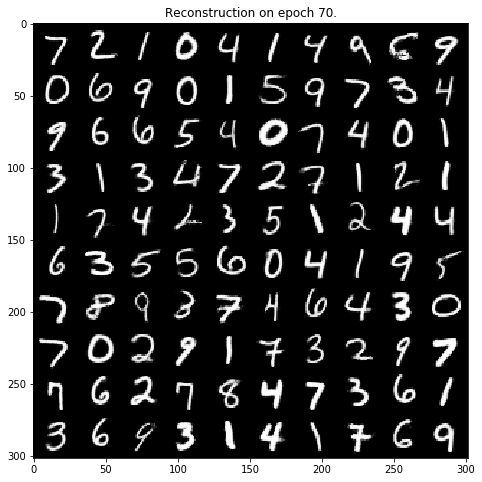

100%|██████████| 20/20.0 [00:07<00:00,  2.88it/s]
  0%|          | 1/600.0 [00:00<01:46,  5.64it/s, wae_obj=-4.49]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.6613



Starting epoch 71


100%|██████████| 600/600.0 [01:38<00:00,  6.14it/s, wae_obj=-5.23]
100%|██████████| 20/20.0 [00:06<00:00,  2.93it/s]
  0%|          | 1/600.0 [00:00<01:42,  5.83it/s, wae_obj=-4.72]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.6995



Starting epoch 72


100%|██████████| 600/600.0 [01:38<00:00,  6.21it/s, wae_obj=-5.12]
100%|██████████| 20/20.0 [00:06<00:00,  2.97it/s]
  0%|          | 1/600.0 [00:00<01:43,  5.80it/s, wae_obj=-4.45]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.6845



Starting epoch 73


100%|██████████| 600/600.0 [01:39<00:00,  6.04it/s, wae_obj=-4.38]
100%|██████████| 20/20.0 [00:06<00:00,  2.86it/s]
  0%|          | 1/600.0 [00:00<01:40,  5.94it/s, wae_obj=-4.22]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.7015



Starting epoch 74


100%|██████████| 600/600.0 [01:38<00:00,  6.16it/s, wae_obj=-4.8] 
100%|██████████| 20/20.0 [00:07<00:00,  2.87it/s]
  0%|          | 1/600.0 [00:00<01:31,  6.55it/s, wae_obj=-4.36]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.7260



Starting epoch 75


100%|██████████| 600/600.0 [01:38<00:00,  6.27it/s, wae_obj=-4.38]
100%|██████████| 20/20.0 [00:06<00:00,  2.94it/s]
  0%|          | 1/600.0 [00:00<01:38,  6.06it/s, wae_obj=-4.81]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.7447



Starting epoch 76


100%|██████████| 600/600.0 [01:38<00:00,  6.13it/s, wae_obj=-4.75]
100%|██████████| 20/20.0 [00:06<00:00,  2.95it/s]
  0%|          | 1/600.0 [00:00<01:46,  5.64it/s, wae_obj=-4.47]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.7598



Starting epoch 77


100%|██████████| 600/600.0 [01:38<00:00,  6.20it/s, wae_obj=-4.01]
100%|██████████| 20/20.0 [00:06<00:00,  2.93it/s]
  0%|          | 1/600.0 [00:00<01:40,  5.93it/s, wae_obj=-4.7]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.7624



Starting epoch 78


100%|██████████| 600/600.0 [01:38<00:00,  6.16it/s, wae_obj=-4.28]
100%|██████████| 20/20.0 [00:06<00:00,  3.14it/s]
  0%|          | 1/600.0 [00:00<01:38,  6.11it/s, wae_obj=-4.19]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.7813



Starting epoch 79


100%|██████████| 600/600.0 [01:38<00:00,  5.99it/s, wae_obj=-4.49]
100%|██████████| 20/20.0 [00:06<00:00,  2.90it/s]
  0%|          | 1/600.0 [00:00<01:40,  5.98it/s, wae_obj=-4.86]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.7957



Starting epoch 80


100%|██████████| 600/600.0 [01:38<00:00,  6.16it/s, wae_obj=-4.34]
  0%|          | 0/20.0 [00:00<?, ?it/s]

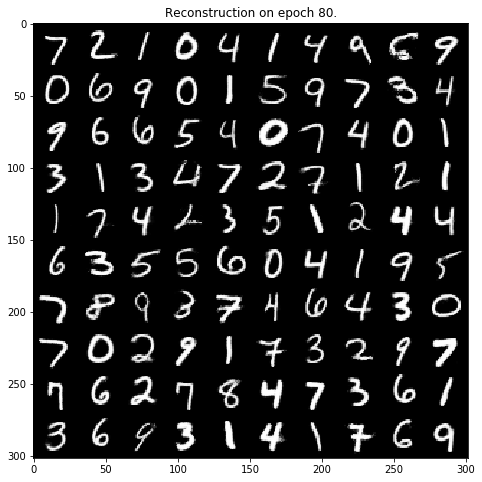

100%|██████████| 20/20.0 [00:07<00:00,  2.63it/s]
  0%|          | 1/600.0 [00:00<01:43,  5.81it/s, wae_obj=-4.64]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.8001



Starting epoch 81


100%|██████████| 600/600.0 [01:38<00:00,  6.09it/s, wae_obj=-4.37]
100%|██████████| 20/20.0 [00:06<00:00,  2.94it/s]
  0%|          | 1/600.0 [00:00<01:37,  6.12it/s, wae_obj=-4.02]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.8044



Starting epoch 82


100%|██████████| 600/600.0 [01:38<00:00,  5.96it/s, wae_obj=-4.5] 
100%|██████████| 20/20.0 [00:06<00:00,  3.05it/s]
  0%|          | 1/600.0 [00:00<01:35,  6.24it/s, wae_obj=-4.76]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.8159



Starting epoch 83


100%|██████████| 600/600.0 [01:38<00:00,  6.12it/s, wae_obj=-4.4] 
100%|██████████| 20/20.0 [00:06<00:00,  2.95it/s]
  0%|          | 1/600.0 [00:00<01:41,  5.90it/s, wae_obj=-4.23]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.8441



Starting epoch 84


100%|██████████| 600/600.0 [01:38<00:00,  6.22it/s, wae_obj=-4.71]
100%|██████████| 20/20.0 [00:06<00:00,  2.93it/s]
  0%|          | 1/600.0 [00:00<01:36,  6.20it/s, wae_obj=-4.85]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.8426



Starting epoch 85


100%|██████████| 600/600.0 [01:38<00:00,  6.14it/s, wae_obj=-4.33]
100%|██████████| 20/20.0 [00:06<00:00,  3.12it/s]
  0%|          | 1/600.0 [00:00<01:43,  5.78it/s, wae_obj=-4.72]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.8448



Starting epoch 86


100%|██████████| 600/600.0 [01:38<00:00,  6.07it/s, wae_obj=-4.53]
100%|██████████| 20/20.0 [00:06<00:00,  3.13it/s]
  0%|          | 1/600.0 [00:00<01:39,  5.99it/s, wae_obj=-4.29]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.8725



Starting epoch 87


100%|██████████| 600/600.0 [01:38<00:00,  6.19it/s, wae_obj=-4.75]
100%|██████████| 20/20.0 [00:06<00:00,  3.10it/s]
  0%|          | 1/600.0 [00:00<01:40,  5.93it/s, wae_obj=-5.25]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.8877



Starting epoch 88


100%|██████████| 600/600.0 [01:37<00:00,  6.29it/s, wae_obj=-4]   
100%|██████████| 20/20.0 [00:06<00:00,  2.95it/s]
  0%|          | 1/600.0 [00:00<01:37,  6.16it/s, wae_obj=-4.47]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.9229



Starting epoch 89


100%|██████████| 600/600.0 [01:38<00:00,  6.09it/s, wae_obj=-4.84]
100%|██████████| 20/20.0 [00:06<00:00,  3.16it/s]
  0%|          | 1/600.0 [00:00<01:34,  6.35it/s, wae_obj=-3.93]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.9391



Starting epoch 90


100%|██████████| 600/600.0 [01:38<00:00,  6.08it/s, wae_obj=-4.39]
  0%|          | 0/20.0 [00:00<?, ?it/s]

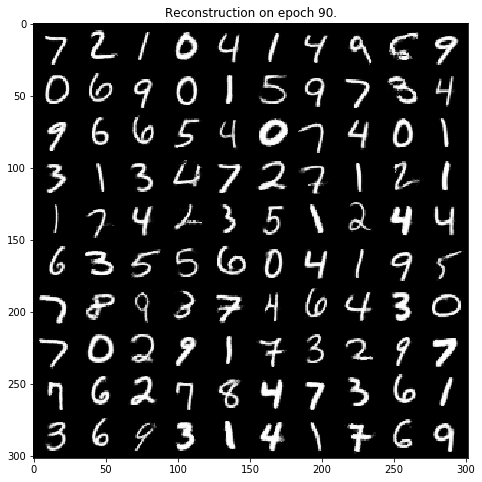

100%|██████████| 20/20.0 [00:07<00:00,  3.03it/s]
  0%|          | 1/600.0 [00:00<01:36,  6.18it/s, wae_obj=-4.29]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -10.0000



Starting epoch 91


100%|██████████| 600/600.0 [01:38<00:00,  5.94it/s, wae_obj=-4.26]
100%|██████████| 20/20.0 [00:06<00:00,  2.96it/s]
  0%|          | 1/600.0 [00:00<01:39,  6.02it/s, wae_obj=-4.34]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.9353



Starting epoch 92


100%|██████████| 600/600.0 [01:38<00:00,  6.11it/s, wae_obj=-4.34]
100%|██████████| 20/20.0 [00:06<00:00,  3.12it/s]
  0%|          | 1/600.0 [00:00<01:32,  6.47it/s, wae_obj=-4.39]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.9696



Starting epoch 93


100%|██████████| 600/600.0 [01:38<00:00,  6.01it/s, wae_obj=-4.13]
100%|██████████| 20/20.0 [00:06<00:00,  3.04it/s]
  0%|          | 1/600.0 [00:00<01:38,  6.10it/s, wae_obj=-4.18]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.9910



Starting epoch 94


100%|██████████| 600/600.0 [01:38<00:00,  5.92it/s, wae_obj=-4.52]
100%|██████████| 20/20.0 [00:06<00:00,  2.96it/s]
  0%|          | 1/600.0 [00:00<01:38,  6.07it/s, wae_obj=-3.88]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -9.9836



Starting epoch 95


100%|██████████| 600/600.0 [01:39<00:00,  6.00it/s, wae_obj=-4.08]
100%|██████████| 20/20.0 [00:06<00:00,  2.91it/s]
  0%|          | 1/600.0 [00:00<01:37,  6.15it/s, wae_obj=-4.05]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -10.0640



Starting epoch 96


100%|██████████| 600/600.0 [01:39<00:00,  5.97it/s, wae_obj=-4.65]
100%|██████████| 20/20.0 [00:06<00:00,  3.19it/s]
  0%|          | 1/600.0 [00:00<01:40,  5.98it/s, wae_obj=-4.51]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -10.0027



Starting epoch 97


100%|██████████| 600/600.0 [01:38<00:00,  6.22it/s, wae_obj=-4.49]
100%|██████████| 20/20.0 [00:06<00:00,  3.18it/s]
  0%|          | 1/600.0 [00:00<01:35,  6.25it/s, wae_obj=-3.98]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -10.0467



Starting epoch 98


100%|██████████| 600/600.0 [01:38<00:00,  6.23it/s, wae_obj=-4.17]
100%|██████████| 20/20.0 [00:06<00:00,  3.02it/s]
  0%|          | 1/600.0 [00:00<01:41,  5.90it/s, wae_obj=-4.3]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -10.0245



Starting epoch 99


100%|██████████| 600/600.0 [01:38<00:00,  5.97it/s, wae_obj=-4.26]
100%|██████████| 20/20.0 [00:06<00:00,  2.99it/s]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -10.0553

Trained the WAE-MMD for 100 epochs.


In [8]:

## Go through and train!
torch.manual_seed(14545)

# Create the VAE
wae = ae.examples.create_mnist_wae_mmd_model(params)
wae.to(params.device)

# Create the optimizer:
optimizer = optim.Adam(wae.parameters(),lr=params.learning_rate,
                       betas=(params.adam_beta_1, params.adam_beta_2))
print(optimizer)

# == Now go through and train and evaluate per epoch ==

# Start by running through and testing before having trained.
test(test_dataloader, params.test_batch_size, params.device, wae, -1)

for epoch in range(params.num_epochs):
    print(f"\n\nStarting epoch {epoch}")
    
    # At set epochs we decay the learning rate.
    if epoch in params.learning_rate_epoch_to_decay_factor_map:
        decay_factor = params.learning_rate_epoch_to_decay_factor_map[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] / decay_factor
        print(f"Reached epoch {epoch} so decaying learning rates by {decay_factor}, optimizer is now:")
        print(optimizer)
    
    # We then go through the training data
    train(train_dataloader, optimizer, params.batch_size, params.device, wae)
    
    # We now run over test set. We only bother doing reconstructions at larger epoch intervals:
    plot_reconstructions_flag = epoch in {0, 1,2,3,4} or ((epoch % 10) == 0)
    test(test_dataloader, params.test_batch_size, params.device, wae, epoch,
         plot_reconstructions=plot_reconstructions_flag)

print(f"Trained the WAE-MMD for {params.num_epochs} epochs.")


In [9]:
# Save the network weights (as training takes some time.)
torch.save(wae.state_dict(), 'wae_mmd_after_100.pt')


  0%|          | 0/20.0 [00:00<?, ?it/s]

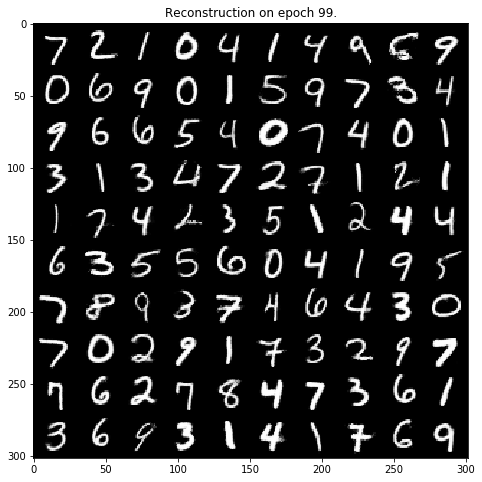

100%|██████████| 20/20.0 [00:07<00:00,  2.96it/s]

Run through the test dataset (10000 num of points). Average (per image) WAE objective was -10.0469



In [10]:
# Do the last reconsruction with image this time
test(test_dataloader, params.test_batch_size, params.device, wae, epoch,
         plot_reconstructions=True)

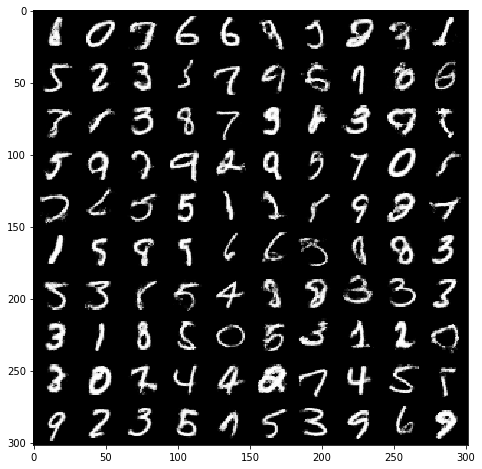

In [11]:
## Now sample from the  latent prior and feed through trained decoder.

num_samples = 100
samples = torch.cat([wae.sample_from_prior_no_grad() for _ in range(num_samples)])
img_grid = make_grid(samples.view(-1,1, 28, 28).cpu(), nrow=10).numpy()
f, ax = plt.subplots(figsize=(8, 8))
ax.imshow(np.transpose(img_grid, (1,2,0)), vmin=0, vmax=1.)
plt.show()
start = False
